C:\Users\pandi\AppData\Local\Temp\ipykernel_14252\1964621774.py:23: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('DDoSdata.csv')


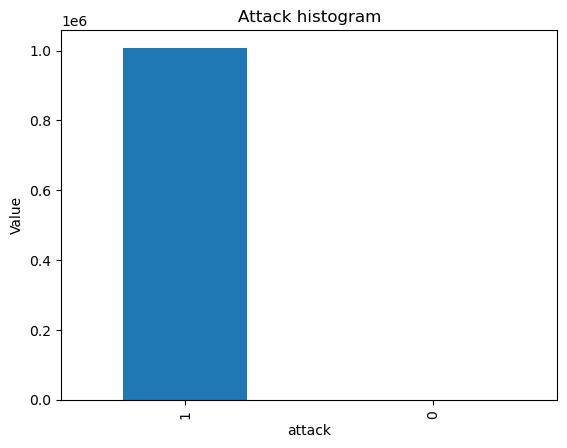

120931/120931 [==============================] - 142s 1ms/step - loss: 0.0085 - accuracy: 0.9989


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from imblearn.over_sampling import SMOTE
from flask import Flask, render_template, request, redirect, session, json
import sqlite3
from keras.models import load_model

# Read data
df_train = pd.read_csv('DDoSdata.csv')
df = df_train.copy()

# Drop unnecessary columns
df.drop(['Unnamed: 0', 'pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto',
         'proto_number', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'state_number', 'ltime', 'seq', 'dur',
         'spkts', 'dpkts', 'sbytes', 'dbytes', "sum",
         'rate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP',
         'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP',
         'AR_P_Proto_P_DstIP',
         'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
         'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'category', 'subcategory', 'protocol_type',
         'service'], axis=1, inplace=True)

# Visualize class distribution
pd.value_counts(df['attack']).plot.bar()
plt.title('Attack histogram')
plt.xlabel('attack')
plt.ylabel('Value')
plt.show()

# Define functions
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def classif_results(y_test, y_pred):
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

    print("Accuracy", metrics.accuracy_score(y_test, y_pred))

    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred))

    auc = roc_auc_score(y_test, y_pred)
    print("AUC Score: ", auc)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plot_roc_curve(fpr, tpr)

def test_scale(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    return X_train, X_test, y_train, y_test

# Prepare data
X = df.drop('attack', axis=1)
y = df['attack']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = test_scale(X, y)

# Convert X_test from NumPy array to DataFrame
X_test_df = pd.DataFrame(X_test, columns=df.drop('attack', axis=1).columns)

# Save test data
X_test_df.to_json("my1.json")

# Load model
model_path = 'model.h5'
CTS = load_model(model_path)


# Define and train classifier
classifier = Sequential()
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu', input_dim=8))
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train, y_train, batch_size=10, epochs=1)


# Initialize Flask app
app = Flask(__name__)
app.secret_key = "secret key"

# Define routes
@app.route("/")
def index():
    return render_template('index.html')

@app.route("/signup")
def signup():
    return render_template('signup.html')

@app.route("/store", methods=["POST"])
def store():
    username = request.form['user']
    name = request.form['user']
    email = request.form['email']
    number = request.form["mobile"]
    password = request.form['password']
    role = "student"
    con = sqlite3.connect('signup.db')
    cur = con.cursor()
    cur.execute("insert into info (user,email, password,mobile,name,'role') VALUES (?, ?, ?, ?, ?, ?)",
                (username, email, password, number, name, role))
    con.commit()
    con.close()
    return redirect("/")

@app.route("/login", methods=["POST"])
def signin():
    mail1 = request.form['user']
    password1 = request.form['password']
    con = sqlite3.connect('signup.db')
    data = 0
    data = con.execute("select user, password,role from info where user = ? AND password = ?",
                       (mail1, password1,)).fetchall()
    print(data)
    if mail1 == 'admin' and password1 == 'admin':
        session['username'] = "Admin"
        return redirect("myful")
    elif mail1 == str(data[0][0]) and password1 == str(data[0][1]):
        print(data)
        session['username'] = data[0][0]
        return redirect("myful")
    else:
        return render_template("signup.html")

@app.route("/myful")
def myful():
    return render_template("next.html")

@app.route("/logout")
def logout():
    session.clear()
    return redirect("/")

@app.route("/check", methods=["POST"])
def check():
    print("working")
    v = open("X_test.txt", "r").read()
    r = json.loads(v)
    y_pred = CTS.predict(r)
    y = (y_pred > 0.5)
    ye = []
    for k in y:
        if k[0]:
            ye.append("attacked")
        else:
            ye.append("not attached")

    return json.dumps(ye)

#
